# Vector-Quantized Variational Autoencoders

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/07/21<br>
**Last modified:** 2021/07/21<br>
**Description:** Training a VQ-VAE for image reconstruction and codebook sampling for generation.

In this example, we will develop a Vector Quantized Variational Autoencoder (VQ-VAE).
VQ-VAE was proposed in
[Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937)
by van der Oord et al. In traditional VAEs, the latent space is continuous and is sampled
from a Gaussian distribution. It is generally harder to learn such a continuous
distribution via gradient descent. VQ-VAEs, on the other hand,
operate on a discrete latent space, making the optimization problem simpler. It does so
by maintaining a discrete *codebook*. The codebook is developed by
discretizing the distance between continuous embeddings and the encoded
outputs. These discrete code words are then fed to the decoder, which is trained
to generate reconstructed samples.

For a detailed overview of VQ-VAEs, please refer to the original paper and
[this video explanation](https://www.youtube.com/watch?v=VZFVUrYcig0).
If you need a refresher on VAEs, you can refer to
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/).
VQ-VAEs are one of the main recipes behind [DALL-E](https://openai.com/blog/dall-e/)
and the idea of a codebook is used in [VQ-GANs](https://arxiv.org/abs/2012.09841).

This example uses references from the
[official VQ-VAE tutorial](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb)
from DeepMind. To run this example, you will need TensorFlow 2.5 or higher, as well as
TensorFlow Probability, which can be installed using the command below.

In [14]:
!pip install -q tensorflow-probability

## Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [31]:
print(tf.__version__)

2.7.0


## `VectorQuantizer` layer

Here, we will implement a custom layer to encapsulate the vector
quantizer logic, which is the central component of VQ-VAEs.
Consider an output from the encoder, with shape `(batch_size, height, width, num_channels)`.
The vector quantizer will first
flatten this output, only keeping the `num_channels` dimension intact. So, the shape would
become `(batch_size * height * width, num_channels)`. The rationale behind this is to
treat the total number of channels as the space for the latent embeddings.

An embedding table is then initialized to learn a codebook. We measure the L2-normalized
distance between the flattened encoder outputs and code words of this codebook. We take the
code that yields the minimum distance, and we apply one-hot encoding to achieve quantization.
This way, the code yielding the minimum distance to the corresponding encoder output is
mapped as one and the remaining codes are mapped as zeros.

Since the quantization process is not differentiable, we apply a
[straight-through estimator](https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html)
in between the decoder and the encoder, so that the decoder gradients are directly propagated
to the encoder. As the encoder and decoder share the same channel space, the hope is that the
decoder gradients will still be meaningful to the encoder.

In [32]:
# DEV
tf.one_hot([3,1,0,2,1], depth=4)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)>

In [33]:

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        ## Latent Embedding Space: K x D/L
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        # input x: (B, H, W, L) -flatten-> (N, L)
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        ## (N, )
        encoding_indices = self.get_code_indices(flattened)
        # (N, K): get one-hot embedding for each instance/row of N
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        # (N, L): get the correcponding embedding for each instance of N from the codebook/E
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        # recover the previous flattened input to (B, H, W, L) in Image/Conv2D case
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        ## Training/BackProp trick?
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    '''
    Output shape: (N, )
    '''
    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        # (N, K)
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        # (N, K)
        distances = (
            # for each row/instance i of the flattened input
            # after broadcasting
            # zei^2 + ek^2 - 2(zei^Tek)
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


**$$$A note on straight-through estimation**:

This line of code does the straight-through estimation part: `quantized = x +
tf.stop_gradient(quantized - x)`. During backpropagation, `(quantized - x)` won't be
included in the computation graph and th gradients obtaind for `quantized`
will be copied for `inputs`. Thanks to [this video](https://youtu.be/VZFVUrYcig0?t=1393)
for helping me understand this technique.

According to the paper, this is the actual implementation to achieve "Approximation of the gradient to the straight-through estimator and just copy gradients from decoder input $z_q(x)$ to encoder output $z_e(x)$. During the backwards pass the gradient $\nabla_z L$ will push the encoder to change its output, which could alter the configuration in the next forward pass (during which  the nearest embedding $z_q(x)$ is passed to the decoder)

In [34]:
test_latent_dim = 8
vq_test = VectorQuantizer(4, test_latent_dim) # K=4, D = 8
# (N, D)
test_input = tf.random.normal(shape=(20, test_latent_dim))

In [35]:
print("Latent Embedding Code Book: ", vq_test.embeddings)
test_vq_idx = vq_test.get_code_indices(test_input) #(N, )
print("Encoding Indices based on nearest neighbour L2-normalized distance: ", test_vq_idx)

Latent Embedding Code Book:  <tf.Variable 'embeddings_vqvae:0' shape=(8, 4) dtype=float32, numpy=
array([[ 0.04576332,  0.03399111,  0.02135419,  0.01053362],
       [-0.03086833,  0.03997787, -0.00030214,  0.01144395],
       [ 0.00854765, -0.01888158, -0.00449674,  0.02431047],
       [-0.00163154, -0.01437665, -0.04559574,  0.04667376],
       [-0.01037705,  0.02478844, -0.01993825,  0.03374263],
       [-0.0125134 , -0.02609142,  0.03245345,  0.02799121],
       [ 0.03124099,  0.03935654,  0.04989013,  0.02431006],
       [-0.02995073, -0.00410522, -0.02278177,  0.00249696]],
      dtype=float32)>
Encoding Indices based on nearest neighbour L2-normalized distance:  tf.Tensor([1 3 1 3 0 3 2 2 1 2 3 2 1 2 2 3 3 0 2 2], shape=(20,), dtype=int64)


In [36]:
### Broadcasting Trick
ze_square = tf.reduce_sum(test_input ** 2, axis=1, keepdims=True) #(N, 1)
print(ze_square)
e_square = tf.reduce_sum(vq_test.embeddings ** 2, axis=0) # (K, )
print(e_square)
# (N, 1), (K, 1) -> (N, K)
print(ze_square + e_square)

tf.Tensor(
[[ 4.740779 ]
 [11.075359 ]
 [ 4.9024277]
 [15.480468 ]
 [14.726372 ]
 [ 7.679924 ]
 [ 4.817663 ]
 [15.878815 ]
 [21.338882 ]
 [ 7.8447886]
 [ 9.645939 ]
 [ 7.715809 ]
 [13.3110485]
 [ 3.9496465]
 [ 8.534668 ]
 [10.280521 ]
 [11.659317 ]
 [ 8.374844 ]
 [ 6.9893975]
 [ 4.3013434]], shape=(20, 1), dtype=float32)
tf.Tensor([0.00526017 0.00617785 0.00701408 0.00553065], shape=(4,), dtype=float32)
tf.Tensor(
[[ 4.746039   4.746957   4.747793   4.7463098]
 [11.08062   11.081537  11.082374  11.08089  ]
 [ 4.9076877  4.9086056  4.909442   4.9079585]
 [15.485728  15.486646  15.487482  15.485998 ]
 [14.731632  14.73255   14.733386  14.731902 ]
 [ 7.685184   7.686102   7.6869383  7.685455 ]
 [ 4.822923   4.823841   4.8246775  4.823194 ]
 [15.884075  15.884993  15.885829  15.884345 ]
 [21.344143  21.34506   21.345896  21.344414 ]
 [ 7.8500485  7.8509665  7.851803   7.8503194]
 [ 9.651199   9.652117   9.652953   9.651469 ]
 [ 7.721069   7.721987   7.722823   7.7213397]
 [13.316309  13.31

## Encoder and decoder

We will now implement the encoder and the decoder for the VQ-VAE. We will keep them small so
that their capacity is a good fit for the MNIST dataset, which we will use to demonstrate
the results. The definitions of the encoder and decoder come from
[this example](https://keras.io/examples/generative/vae).

In [37]:

def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder().output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


## Standalone VQ-VAE model

In [38]:

def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


Note that the output channels of the encoder should match the `latent_dim` for the vector
quantizer.

## Wrapping up the training loop inside `VQVAETrainer`

In [39]:

class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


## Load and preprocess the MNIST dataset

In [40]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

## Train the VQ-VAE model

In [79]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
# vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)
vqvae_trainer.fit(x_train_scaled, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 2.4064 - reconstruction_loss: 0.3453 - vqvae_loss: 1.7604
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 2.0226 - reconstruction_loss: 0.1526 - vqvae_loss: 1.8563
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.7724 - reconstruction_loss: 0.1175 - vqvae_loss: 0.6478
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.4779 - reconstruction_loss: 0.0946 - vqvae_loss: 0.3793
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3674 - reconstruction_loss: 0.0820 - vqvae_loss: 0.2829
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3228 - reconstruction_loss: 0.0752 - vqvae_loss: 0.2461
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3056 - reconstruction_loss: 0.0705 - vqvae_loss: 0.2339
Epoch 8/10
469/469 [==============================] - 3s 7ms/step - loss: 0.

## Reconstruction results on the test set

<class 'numpy.ndarray'> (10, 28, 28, 1)


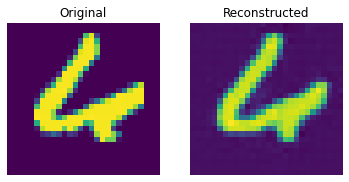

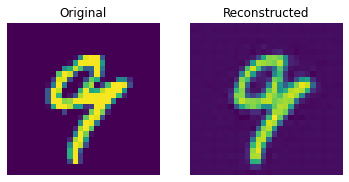

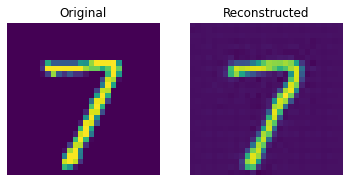

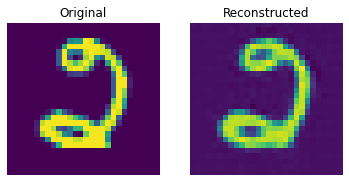

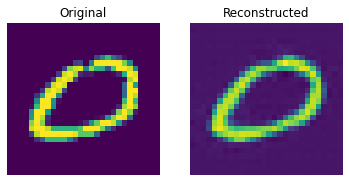

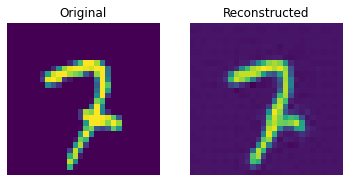

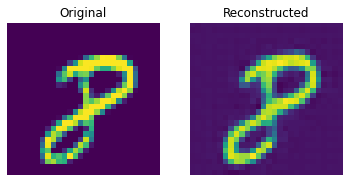

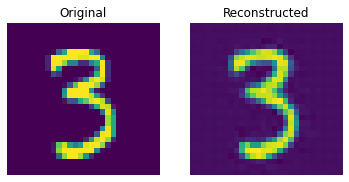

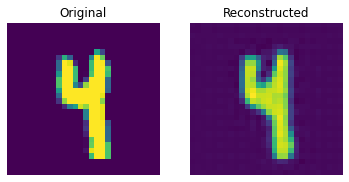

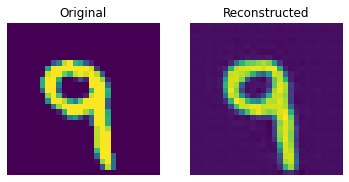

In [80]:

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
# Random picked 10 test images
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

print(type(reconstructions_test), reconstructions_test.shape)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

These results look decent. You are encouraged to play with different hyperparameters
(especially the number of embeddings and the dimensions of the embeddings) and observe how
they affect the results.

## Visualizing the discrete codes

In [81]:
test_images.squeeze().shape

(10, 28, 28)

Encoded Latent Representation Shape:  (10, 7, 7, 16) (490, 16)
CB indices raw shape:  (490,)
CB indices Inverse-Flatten shape:  (10, 7, 7)


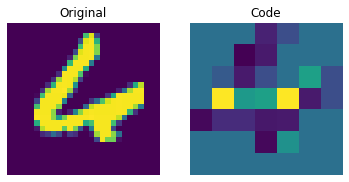

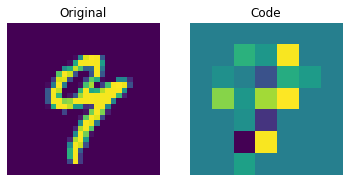

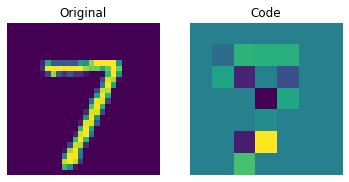

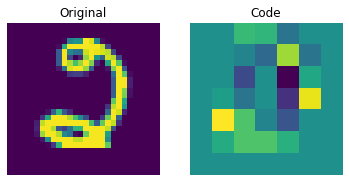

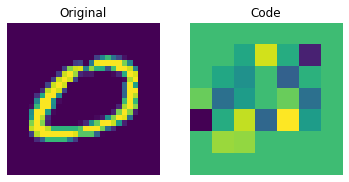

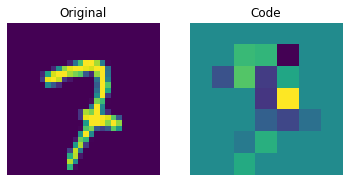

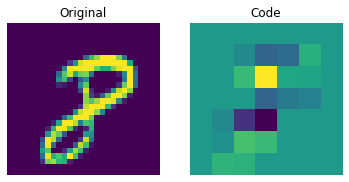

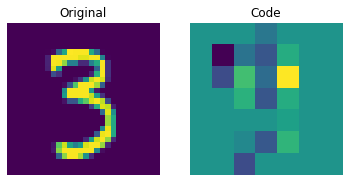

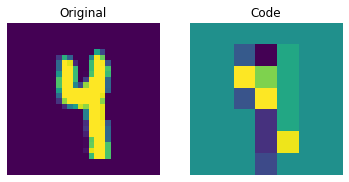

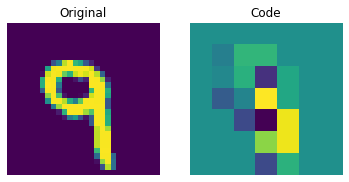

In [82]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
#(BxH'xW', D) H'/W' indicate compressed output dim of encoder
print("Encoded Latent Representation Shape: ", encoded_outputs.shape, flat_enc_outputs.shape)
#(BxHxW, )
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print("CB indices raw shape: ", codebook_indices.shape)
# (B, H, W)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print("CB indices Inverse-Flatten shape: ", codebook_indices.shape)

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

The figure above shows that the discrete codes have been able to capture some
regularities from the dataset. Now, you might wonder, ***how do we use these codes to
generate new samples?*** Specifically, how do we sample from this codebook to create
novel examples? Since **these codes are discrete and we imposed a categorical distribution**
on them, we cannot use them yet to generate anything meaningful. ***These codes were not
updated during the training process as well(???)***. So, they need to be adjusted further so that
we can use for them the subsequent image generation task. The authors use a PixelCNN to
train these codes so that they can be used as powerful priors to generate novel examples.

PixelCNN was proposed in
[Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)
by van der Oord et al. We will borrow code from
[this example](https://keras.io/examples/generative/pixelcnn/)
to develop a PixelCNN. It's an auto-regressive generative model where the current outputs
are conditioned on the prior ones. In other words, a PixelCNN generates an image on a
pixel-by-pixel basis.

## PixelCNN hyperparameters

In [83]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
# reduce BatchSize and LatentDim
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)


Don't worry about the input shape. It'll become clear in the following sections.

## PixelCNN model

Majority of this comes from
[this example](https://keras.io/examples/generative/pixelcnn/).

In [84]:
### PixelConv: Conv with masking
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        print("Build PixelConv ..., input shape: {}".format(input_shape))
        # input_shape (B, H, W, L/C/D)
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        # kernel Shape: (kernel_H, kernel_W, input_channel, output_channel/filters)
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        #  To make sure the CNN can only use information about pixels above
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        # and to the left of the current pixel
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

In [85]:
# DEV
p_conv = PixelConvLayer(mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same")

## Initialization...
### 1. through build
# p_conv.build(tf.TensorShape([None, 7, 7, 128]))
### 2. through forward pass
test_input = tf.random.normal(shape=(20, 7, 7, 128))
print(test_input.shape)
print("Pixel Conv Output Shape: ", p_conv(test_input).shape)


(20, 7, 7, 128)
Build PixelConv ..., input shape: (20, 7, 7, 128)
Pixel Conv Output Shape:  (20, 7, 7, 128)


In [86]:
# kernel Shape: (kernel_H, kernel_W, input_channel, output_channel/filters)
test_mask = np.zeros(shape=p_conv.conv.kernel.shape)
print(test_mask.shape)
test_mask[: test_mask.shape[0]//2, ...] = 1.
test_mask[test_mask.shape[0]//2, : test_mask.shape[0]//2, ...] = 1.0


(7, 7, 128, 128)


In [87]:
t_test_mask = tf.transpose(test_mask, perm=[2, 3, 0, 1])
print(t_test_mask.shape)
print(t_test_mask[0][0])
print(t_test_mask[127][63])

(128, 128, 7, 7)
tf.Tensor(
[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]], shape=(7, 7), dtype=float64)
tf.Tensor(
[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]], shape=(7, 7), dtype=float64)


In [88]:
## Dev: Uniform distribution
a = test_mask[:, 0, 1, 0]
print(a)
tf.random.uniform(a.shape) # output random values from a uniform distribution of range(0, 1)

[1. 1. 1. 1. 0. 0. 0.]


<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.9555751 , 0.12969291, 0.80409694, 0.6171354 , 0.24891043,
       0.8053918 , 0.12683702], dtype=float32)>

In [89]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
# class PixelConvLayer(layers.Layer):
#     def __init__(self, mask_type, **kwargs):
#         super(PixelConvLayer, self).__init__()
#         self.mask_type = mask_type
#         self.conv = layers.Conv2D(**kwargs)

#     def build(self, input_shape):
#         # input_shape (B, H, W, L/C/D)
#         # Build the conv2d layer to initialize kernel variables
#         self.conv.build(input_shape)
#         # Use the initialized kernel to create the mask
#         kernel_shape = self.conv.kernel.get_shape()
#         self.mask = np.zeros(shape=kernel_shape)
#         self.mask[: kernel_shape[0] // 2, ...] = 1.0
#         self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
#         if self.mask_type == "B":
#             self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

#     def call(self, inputs):
#         self.conv.kernel.assign(self.conv.kernel * self.mask)
#         return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
# (B, pixel_CNN_H, pixel_CNN_W, K)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Build PixelConv ..., input shape: (None, 7, 7, 128)
Build PixelConv ..., input shape: (None, 7, 7, 128)
Build PixelConv ..., input shape: (None, 7, 7, 128)
Build PixelConv ..., input shape: (None, 7, 7, 128)
Build PixelConv ..., input shape: (None, 7, 7, 128)
Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 7, 7)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 7, 7, 128)         0         
                                                                 
 pixel_conv_layer_1 (PixelCo  (None, 7, 7, 128)        802944    
 nvLayer)                                                        
                                                                 
 residual_block (ResidualBlo  (None, 7, 7, 128)        98624     
 ck)                                                         

## Prepare data to train the PixelCNN

We will train the PixelCNN to learn a categorical distribution of the discrete codes.
First, we will generate code indices using the encoder and vector quantizer we just
trained. Our training objective will be to minimize the crossentropy loss between these
indices and the PixelCNN outputs. Here, **the number of categories is equal to the number
of embeddings present in our codebook (128 in our case)**. The PixelCNN model is
trained to learn a distribution (as opposed to minimizing the L1/L2 loss), which is where
it gets its generative capabilities from.

In [91]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs) # each pixel matches a index mapping to an embedding in codebook

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}") # (B, pixel_CNN_H, pixel_CNN_W)
print("Training data sample, idex of coodbook imbeddings: ", codebook_indices[0])

Shape of the training data for PixelCNN: (60000, 7, 7)
Training data sample, idex of coodbook imbeddings:  [[ 66  66  66  66  66  52  66]
 [ 66  58  40 126  50  83  66]
 [ 66  33  23  14  66  66  66]
 [ 66  66  33  37  49  66  66]
 [ 66  66  73  85  38  66  66]
 [ 73  40  38  82  66  66  66]
 [ 66  33  66  66  66  66  66]]


## PixelCNN training

In [92]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
)

Epoch 1/10
422/422 [==============================] - 5s 9ms/step - loss: 1.6314 - accuracy: 0.6505 - val_loss: 1.1101 - val_accuracy: 0.6836
Epoch 2/10
422/422 [==============================] - 3s 8ms/step - loss: 1.0391 - accuracy: 0.6956 - val_loss: 0.9996 - val_accuracy: 0.7029
Epoch 3/10
422/422 [==============================] - 3s 7ms/step - loss: 0.9710 - accuracy: 0.7087 - val_loss: 0.9598 - val_accuracy: 0.7106
Epoch 4/10
422/422 [==============================] - 3s 8ms/step - loss: 0.9374 - accuracy: 0.7154 - val_loss: 0.9395 - val_accuracy: 0.7142
Epoch 5/10
422/422 [==============================] - 3s 8ms/step - loss: 0.9157 - accuracy: 0.7199 - val_loss: 0.9208 - val_accuracy: 0.7176
Epoch 6/10
422/422 [==============================] - 3s 7ms/step - loss: 0.9008 - accuracy: 0.7230 - val_loss: 0.9093 - val_accuracy: 0.7200
Epoch 7/10
422/422 [==============================] - 3s 8ms/step - loss: 0.8879 - accuracy: 0.7259 - val_loss: 0.9027 - val_accuracy: 0.7216
Epoch 

We can improve these scores with more training and hyperparameter tuning.

## Codebook sampling

Now that our PixelCNN is trained, we can sample distinct codes from its outputs and pass
them to our decoder to generate novel images.

In [93]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
x = pixel_cnn(inputs, training=False)
# logits: (B, pixelCNN_H/encoded_output_H of VQ-VQE, pixel_CNN_W, num_codebook_embeddings/K)
dist = tfp.distributions.Categorical(logits=x)
sampled = dist.sample()
sampler = keras.Model(inputs, sampled)

In [94]:
# Debug
print(x.shape)
# sampler.summary()

(None, 7, 7, 128)


We now construct a prior to generate images. Here, we will generate 10 images.

In [189]:
# Create an empty array of priors/code_book indices array for each laten space image (L_H, L_W).
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

Prior shape: (10, 7, 7)


We can now use our decoder to generate the images.

(10, 7, 7, 128)
(10, 7, 7, 16)
(10, 7, 7, 16)


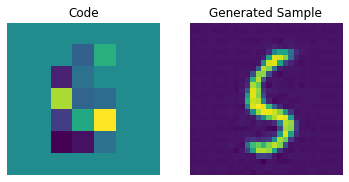

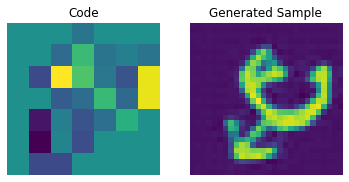

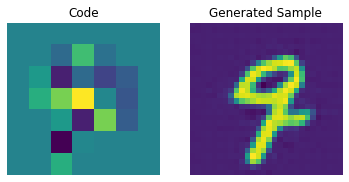

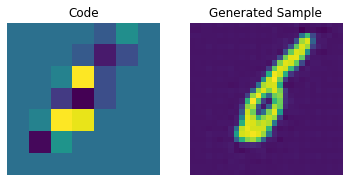

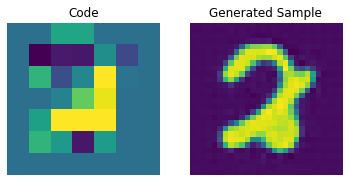

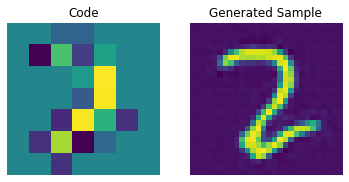

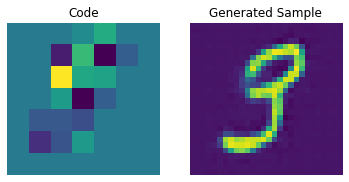

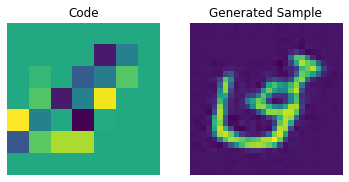

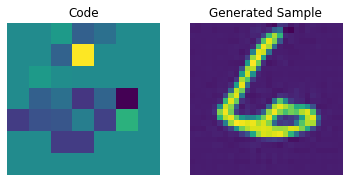

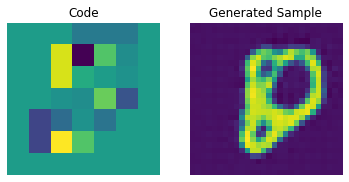

In [193]:
# Perform an embedding lookup. 
## retrieve zq accordingly based on cookbook embedding indices, and input to the decoder
pretrained_embeddings = quantizer.embeddings
# (B, eH, eW, K/num codebook embeddings)
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
print(priors_ohe.shape)
# eq: (B, eH, eW, L/enc_dim, codebook_dim, dec_dim) (for gradient 'straight-through')
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
print(quantized.shape)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))
print(quantized.shape)

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

We can enhance the quality of these generated samples by tweaking the PixelCNN.

## Additional notes

* After the VQ-VAE paper was initially released, the authors developed an exponential
moving averaging scheme to update the embeddings inside the quantizer. If you're
interested you can check out
[this snippet](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py#L124).
* To further enhance the quality of the generated samples,
[VQ-VAE-2](https://arxiv.org/abs/1906.00446) was proposed that follows a cascaded
approach to learn the codebook and to generate the images.

### PixelCNN with Conditional hidden input

In [16]:
### Using TFDP library
import tensorflow_datasets as tfds


In [17]:
# Load MNIST from tensorflow_datasets
data = tfds.load('mnist')
train_data, test_data = data['train'], data['test']


(28, 28, 1) () tf.Tensor(4, shape=(), dtype=int64)


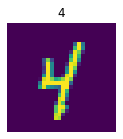

(28, 28, 1) () tf.Tensor(1, shape=(), dtype=int64)


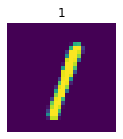

(28, 28, 1) () tf.Tensor(0, shape=(), dtype=int64)


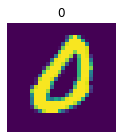

In [65]:
for data in train_data.take(3):
  # Image with integer from [0, 255)]
  print(data['image'].shape, data['label'].shape, data['label'])
  fig = plt.figure(figsize=(2, 2))
  plt.subplot(1, 1, 1)
  plt.imshow(data['image'].numpy().squeeze())
  plt.title(data['label'].numpy())
  plt.axis("off")

  plt.show()
  # print(data['image'])

#### Model Def

In [20]:
image_shape = (28, 28, 1)
# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN(
    image_shape=image_shape,
    num_resnet=1,
    num_hierarchies=1,
    num_filters=16,
    num_logistic_mix=5,
    dropout_p=.3,
)

# Define the model input
image_input = layers.Input(shape=image_shape)

# Define the log likelihood for the loss fn
log_prob = dist.log_prob(image_input)

# Define the model
## Input: (B, H, W, 1)
## Output
model = keras.Model(inputs=image_input, outputs=log_prob)

In [21]:
test_input = tf.zeros(shape=(3, 28, 28, 1))
print(test_input.shape)
model(test_input)

(3, 28, 28, 1)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1197.5366, -1197.5366, -1197.5366], dtype=float32)>

In [ ]:
samples = dist.sample(5)
print(samples.shape)
print(samples[0])

KeyboardInterrupt: ignored

In [ ]:
model.summary()

In [23]:
## Training (with no conditional input)
def image_preprocess(x):
  x['image'] = tf.cast(x['image'], tf.float32)
  return (x['image'],)  # (input, output) of the model


def image_preprocess_label(x):
  x['image'] = tf.cast(x['image'], tf.float32)
  # return model (inputs, outputs): inputs are (image, label) and there are no
  # outputs
  return ((x['image'], x['label']),) # the input is tupled, and no output

batch_size = 16
train_ds = train_data.map(image_preprocess).batch(batch_size).shuffle(1000)
optimizer = keras.optimizers.Adam()

In [24]:
for data in train_ds.take(3):
  print(data[0].shape)

(16, 28, 28, 1)
(16, 28, 28, 1)
(16, 28, 28, 1)


In [25]:
model.add_loss(-tf.reduce_mean(log_prob))

# Compile and train the model
model.compile(
    optimizer=keras.optimizers.Adam(.001),
    metrics=[])

model.fit(train_ds, epochs=10, verbose=True)

Epoch 1/10
3750/3750 [==============================] - 108s 28ms/step - loss: 743.2513
Epoch 2/10
3750/3750 [==============================] - 105s 28ms/step - loss: 662.4865
Epoch 3/10
3750/3750 [==============================] - 106s 28ms/step - loss: 649.4509
Epoch 4/10
3750/3750 [==============================] - 106s 28ms/step - loss: 642.4157
Epoch 5/10
3750/3750 [==============================] - 106s 28ms/step - loss: 636.6602
Epoch 6/10
3750/3750 [==============================] - 105s 28ms/step - loss: 633.6218
Epoch 7/10
3750/3750 [==============================] - 106s 28ms/step - loss: 631.0873
Epoch 8/10
3750/3750 [==============================] - 105s 28ms/step - loss: 627.6663
Epoch 9/10
3750/3750 [==============================] - 106s 28ms/step - loss: 626.2527
Epoch 10/10
3750/3750 [==============================] - 104s 28ms/step - loss: 624.2189


In [ ]:
# sample five images from the trained model
samples = dist.sample(5)

<class 'tensorflow.python.framework.ops.EagerTensor'> (5, 28, 28, 1)


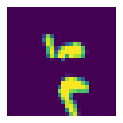

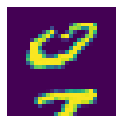

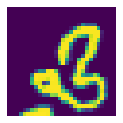

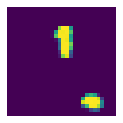

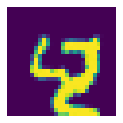

In [69]:
print(type(samples), samples.shape) #(B, image_input_shape)
for i in range(len(samples)):
    fig = plt.figure(figsize=(2, 2))
    plt.subplot(1, 1, 1)
    plt.imshow(samples[i].numpy().squeeze()) #.squeeze())
    # plt.title("Original")
    plt.axis("off")

    plt.show()

In [55]:
## Training (with conditional input)
train_ds_label = train_data.map(image_preprocess_label).batch(batch_size).shuffle(1000)
optimizer = keras.optimizers.Adam()

for data in train_ds_label.take(1):
  print(type(data), len(data), data[0][0].shape, data[0][1]) #(note that no outputs...)



<class 'tuple'> 1 (16, 28, 28, 1) tf.Tensor([8 8 6 1 0 9 9 6 1 7 5 4 9 3 1 9], shape=(16,), dtype=int64)


In [ ]:
image_shape = (28, 28, 1)
label_shape = ()
class_cond_dist = tfp.distributions.PixelCNN(
    image_shape=image_shape,
    conditional_shape=label_shape,
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=5,
    dropout_p=.3,
)

image_input = layers.Input(shape=image_shape)
label_input = layers.Input(shape=label_shape)

class_cond_log_prob = class_cond_dist.log_prob(image_input, conditional_input=label_input)

class_cond_model = keras.Model(
    inputs=[image_input, label_input], outputs=class_cond_log_prob)
class_cond_model.add_loss(-tf.reduce_mean(class_cond_log_prob))
class_cond_model.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[])
class_cond_model.fit(train_ds_label, epochs=10)

<class 'tensorflow.python.framework.ops.EagerTensor'> (5, 28, 28, 1)


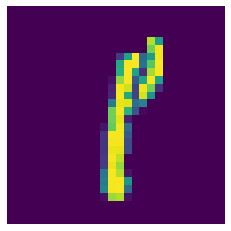

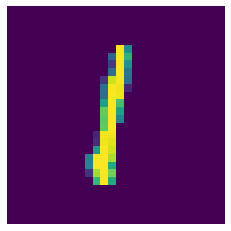

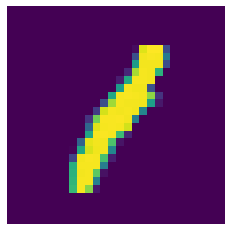

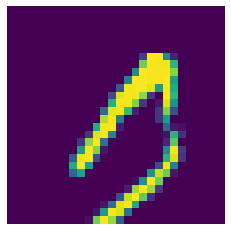

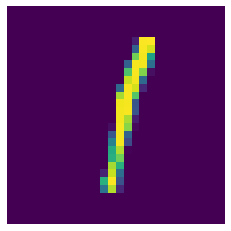

In [78]:
# $$$ samples of the digit '5'
samples = class_cond_dist.sample(5, conditional_input=1)
print(type(samples), samples.shape) #(B, image_input_shape)
for i in range(len(samples)):
    # fig = plt.figure(figsize=(5, 2))
    plt.subplot(1, 1, 1)
    plt.imshow(samples[i].numpy().squeeze()) #.squeeze())
    # plt.title("Original")
    plt.axis("off")

    plt.show()

In [74]:
# Take 4 samples each of the digits '1', '2', '3'.
# Note that when a batch of conditional input is passed, the sample shape
# (the first argument of `dist.sample`) must have its last dimension(s) equal
# the batch shape of the conditional input (here, (3,)).
samples = class_cond_dist.sample((4, 3), conditional_input=[1., 2., 3.])

In [75]:
print(samples.shape)

(4, 3, 28, 28, 1)


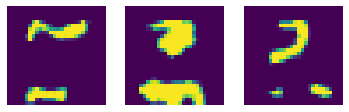

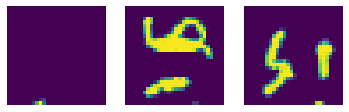

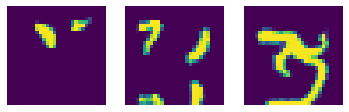

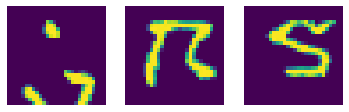

In [76]:
for i in range(len(samples)):
    # fig = plt.figure(figsize=(5, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(samples[i][0].numpy().squeeze()) #.squeeze())
    # plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(samples[i][1].numpy().squeeze()) #.squeeze())
    # plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(samples[i][2].numpy().squeeze()) #.squeeze())
    # plt.title("Original")
    plt.axis("off")

    plt.show()

#### Back to use the Lib PixelCNN to generate priors for our VQ-VAE

In [ ]:
### DEBUG
for data in train_data.take(10):
  image_data = tf.cast(data['image'], tf.float32)
  print(data['image'].shape, data['label'])
  print(image_data[0].numpy().transpose())
  data_scaled = (image_data / 255.0) - 0.5
  print(data_scaled[0].numpy().transpose())
  # (B, eH, eW, L)
  # encoded_outputs = encoder.predict(tf.expand_dims(data_scaled, axis=0))
  encoded_outputs = encoder(tf.expand_dims(data_scaled, axis=0))
  print(encoded_outputs.shape)
  flat_enc_outputs = encoded_outputs.numpy().reshape(-1, encoded_outputs.shape[-1])
  print(flat_enc_outputs.shape)
  # each pixel matches a index mapping to an embedding in codebook
  codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
  # (B, eH, eW)
  codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
  print(codebook_indices.shape)
  print(codebook_indices[0])

  ## For Debug, reconstruction
  # Perform an embedding lookup.
  pretrained_embeddings = quantizer.embeddings
  priors_ohe = tf.one_hot(codebook_indices.astype("int32"), vqvae_trainer.num_embeddings).numpy()
  quantized = tf.matmul(
      priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
  )
  quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))
  print("Zq Shape: ", quantized.shape) #(B, dH, hW, L)

  # Generate novel images.
  decoder = vqvae_trainer.vqvae.get_layer("decoder")
  generated_samples = decoder.predict(quantized)
  print("Generated/Reconstructed image: ", generated_samples.shape)

  # For Debug, plotting
  plt.subplot(1, 3, 1)
  plt.imshow(data_scaled.numpy().squeeze() + 0.5)
  plt.title("Original")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.imshow(codebook_indices[0])
  plt.title("Code")
  plt.axis("off")

  plt.subplot(1, 3, 3)
  plt.imshow(generated_samples[0].squeeze() + 0.5)
  plt.title("Reconstructed")
  plt.axis("off")
  plt.show()


In [134]:
## Reload training labels
(_, y_train), (_, _) = keras.datasets.mnist.load_data()
print(y_train.shape)

(60000,)


In [129]:
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs) # each pixel matches a index mapping to an embedding in codebook

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(codebook_indices.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))
print("Zq Shape: ", quantized.shape) #(B, dH, hW, L)

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)
print("Generated/Reconstructed image: ", generated_samples.shape)

Zq Shape:  (60000, 7, 7, 16)
Generated/Reconstructed image:  (60000, 28, 28, 1)


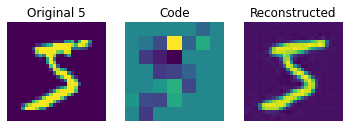

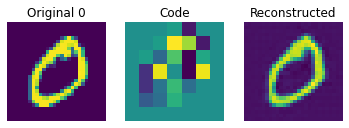

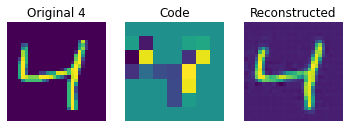

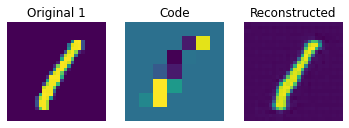

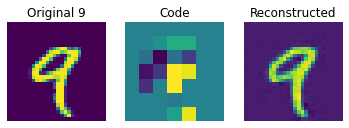

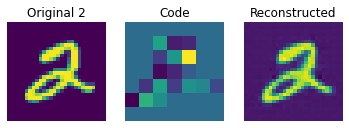

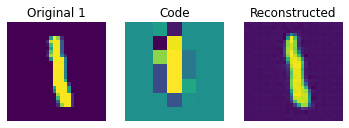

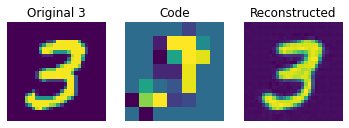

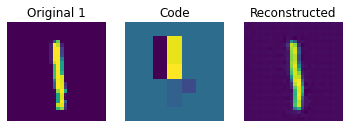

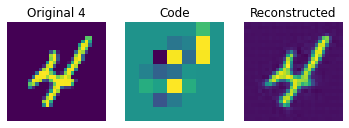

In [135]:
for i in range(10):
  data_scaled = x_train_scaled[i]
  # For Debug, plotting
  plt.subplot(1, 3, 1)
  plt.imshow(data_scaled.squeeze() + 0.5)
  plt.title(f"Original {y_train[i]}")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.imshow(codebook_indices[i])
  plt.title("Code")
  plt.axis("off")

  plt.subplot(1, 3, 3)
  plt.imshow(generated_samples[i].squeeze() + 0.5)
  plt.title("Reconstructed")
  plt.axis("off")
  plt.show()

In [128]:
codebook_indices.shape

(60000, 7, 7)

In [132]:
def image_preprocess_vq_encoder(x):
  # x['image'] = tf.cast(x['image'], tf.float32)
  # return model (inputs, outputs): inputs are (image, label) and there are no
  # outputs

  image_data = tf.cast(data['image'], tf.float32)
  # print(data['image'].shape, data['label'])
  # print(image_data[0].numpy().transpose())
  data_scaled = (image_data / 255.0) - 0.5
  # print(data_scaled[0].numpy().transpose())
  # (B, eH, eW, L)
  encoded_outputs = encoder(tf.expand_dims(data_scaled, axis=0))
  # print(encoded_outputs.shape)
  flat_enc_outputs = encoded_outputs.numpy().reshape(-1, encoded_outputs.shape[-1])
  # print(flat_enc_outputs.shape)
  # each pixel matches a index mapping to an embedding in codebook
  codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
  # (B, eH, eW)
  codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
  # print(codebook_indices.shape)
  # print(codebook_indices[0])
  return ((codebook_indices, x['label']),) # the input is tupled, and no output

## TODO: operations not supported in tf function...
batch_size = 16
# train_ds_vq_vae = train_data.map(image_preprocess_vq_encoder).batch(batch_size).shuffle(1000)

In [179]:

# tf.pad(codebook_indices, tf.constant([[0,0], [1, 0,], [1, 0]]), 'CONSTANT')

In [211]:
### Create Data set
# train_ds_vq_vae = tf.data.Dataset.from_tensor_slices(((np.expand_dims(codebook_indices, -1), y_train), )).shuffle(1000).batch(batch_size)
# train_ds_vq_vae_nc = tf.data.Dataset.from_tensor_slices((np.expand_dims(codebook_indices, -1), )).shuffle(1000).batch(batch_size)
## add padding to cast from (7,7) to  (8, 8)
paddings = tf.constant([[0,0], [1, 0,], [1, 0]])
padded_codebook_indices = tf.pad(codebook_indices, paddings, 'CONSTANT')
train_ds_vq_vae_nc = tf.data.Dataset.from_tensor_slices((np.expand_dims(padded_codebook_indices, -1), )).shuffle(1000).batch(batch_size)
train_ds_vq_vae = tf.data.Dataset.from_tensor_slices(((np.expand_dims(padded_codebook_indices, -1), y_train), )).shuffle(1000).batch(batch_size)


In [212]:
for batch in train_ds_vq_vae_nc.take(3):
  print(type(batch), len(batch))
  print(batch[0].shape)
  print(batch[0][0].numpy().squeeze())

<class 'tuple'> 1
(16, 8, 8, 1)
[[  0   0   0   0   0   0   0   0]
 [  0  66  66  66  58  87  66  66]
 [  0  66  66  66  80 126 122  66]
 [  0  66  66  87 103  83  66  66]
 [  0  66 105  93 109  78  66  66]
 [  0  75  49  52 103  67  66  66]
 [  0  33  41  50  83  66  66  66]
 [  0  66  66  66  66  66  66  66]]
<class 'tuple'> 1
(16, 8, 8, 1)
[[ 0  0  0  0  0  0  0  0]
 [ 0 66 66 66 66 52 66 66]
 [ 0 66 66 73 93 13 66 66]
 [ 0 66 66 23 87 85 52 66]
 [ 0 66 66 48 78 33 66 66]
 [ 0 66 66 72 88 66 66 66]
 [ 0 66 66 13 48 66 66 66]
 [ 0 66 66 33 66 66 66 66]]
<class 'tuple'> 1
(16, 8, 8, 1)
[[  0   0   0   0   0   0   0   0]
 [  0  66  66  66  66  66  66  66]
 [  0  66  66  73  85  14  66  66]
 [  0  66   6  83  75  78  66  66]
 [  0  66  66  66   6 122  66  66]
 [  0  66  66  66   6 122  66  66]
 [  0  66  66  66  23  54  66  66]
 [  0  66  66  66  41  54  66  66]]


In [213]:
for batch in train_ds_vq_vae.take(3):
  print(type(batch), len(batch))
  print(batch[0][0].shape, batch[0][1])
  print(batch[0][0][0].numpy().squeeze())

<class 'tuple'> 1
(16, 8, 8, 1) tf.Tensor([6 8 4 3 4 1 7 7 0 4 4 3 1 7 2 2], shape=(16,), dtype=uint8)
[[  0   0   0   0   0   0   0   0]
 [  0  66  66  66  87  67  66  66]
 [  0  66  66  58  50  66  66  66]
 [  0  66  66 126  73  85  52  66]
 [  0  66   6  67  47  31 122  66]
 [  0  66   6  49  40  82  66  66]
 [  0  66  33  80  79  66  66  66]
 [  0  66  66  66  66  66  66  66]]
<class 'tuple'> 1
(16, 8, 8, 1) tf.Tensor([0 4 4 2 8 1 1 9 7 0 9 9 4 8 1 0], shape=(16,), dtype=uint8)
[[  0   0   0   0   0   0   0   0]
 [  0  66  66  66  52  66  66  66]
 [  0  66  66  58  93  78  66  66]
 [  0  66  66  72  66  23  54  66]
 [  0  66  75 122  66  75 122  66]
 [  0  66  75  14  66   6  54  66]
 [  0  66  33  76  85  82  66  66]
 [  0  66  66  33  66  66  66  66]]
<class 'tuple'> 1
(16, 8, 8, 1) tf.Tensor([3 1 1 7 1 5 5 1 9 1 0 0 2 7 0 5], shape=(16,), dtype=uint8)
[[  0   0   0   0   0   0   0   0]
 [  0  66  66  66  66  66  66  66]
 [  0  66  66  40  43  49  66  66]
 [  0  66 105  82  73  3

In [ ]:
# print(np.expand_dims(codebook_indices, -1)[0].squeeze())
# print(codebook_indices[0])
image_shape = padded_codebook_indices.shape[1:] + (1,) #(7, 7, 1)
print(image_shape)
label_shape = ()
codebook_dist = tfp.distributions.PixelCNN(
    image_shape=image_shape,
    conditional_shape=label_shape,
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=5,
    dropout_p=.3,
    high=127,
    low=0,
)

tf.print("[DEBUG].... Construct Model...")
image_input = layers.Input(shape=image_shape)
label_input = layers.Input(shape=label_shape)

codebook_log_prob = codebook_dist.log_prob(image_input, conditional_input=label_input)
# codebook_log_prob = codebook_dist.log_prob(image_input)


codebook_class_cond_model = keras.Model(
    inputs=[image_input, label_input], outputs=codebook_log_prob)
# codebook_class_model = keras.Model(inputs=image_input, outputs=codebook_log_prob)
codebook_class_cond_model.add_loss(-tf.reduce_mean(codebook_log_prob))
codebook_class_cond_model.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[])
codebook_class_cond_model.fit(train_ds_vq_vae, epochs=10)

(8, 8, 1)
[DEBUG].... Construct Model...
Epoch 1/10
2676/3750 [====================>.........] - ETA: 1:09 - loss: 131.1943

<class 'tensorflow.python.framework.ops.EagerTensor'> (5, 8, 8, 1)
(5, 7, 7)
(5, 28, 28, 1)
(7, 7)


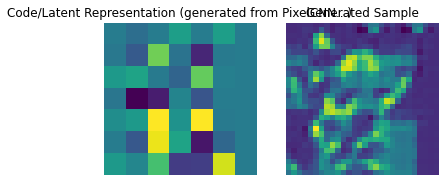

(7, 7)


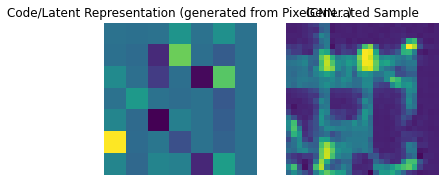

(7, 7)


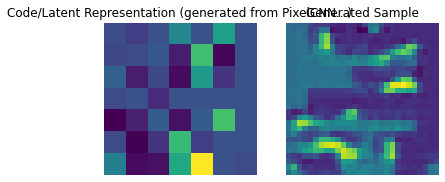

(7, 7)


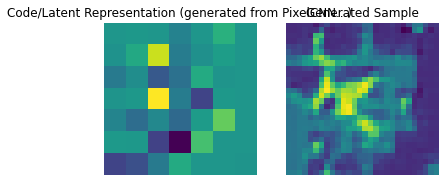

(7, 7)


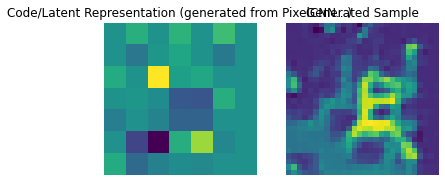

In [209]:
samples = codebook_dist.sample(5)
print(type(samples), samples.shape) #(B, image_input_shape)

# (B, 7, 7) for current set up
unpad_samples = samples.numpy().squeeze()[:, 1:, 1:] 
print(unpad_samples.shape)

# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(unpad_samples.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)
# (B, H, W, C)
print(generated_samples.shape)

for i in range(len(unpad_samples)):
    # fig = plt.figure(figsize=(5, 2))
    
    ## TODO: remove paddings...
    print(unpad_sample.shape)
    # print(unpad_sample)


    # Plotting
    plt.subplot(1, 2, 1)
    plt.imshow(unpad_samples[i]) #.squeeze())
    plt.title("Code/Latent Representation (generated from PixelCNN...)")
    plt.axis("off")


    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")


    plt.show()

In [206]:
# t = samples.numpy().squeeze()[:, 1:, 1:]
# print(t.shape)
# print(t[0])
# '''
# [[66. 79. 70. 72. 66. 57. 66.]
#  [66. 52. 52. 92. 75. 52. 66.]
#  [78. 74. 55. 51. 23. 66. 66.]
#  [64. 50. 86. 78. 66. 51. 66.]
#  [79. 73. 47. 96. 47. 66. 66.]
#  [64. 66. 93. 55. 66. 66. 65.]
#  [78. 72. 66. 91.  0. 66. 66.]]
#  '''

In [198]:
print(samples[0].numpy().squeeze())
print(samples[0].numpy().squeeze()[1:, 1:])

[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  66.  62.  66.  77.  66.  57.  66.]
 [  0.  65.  68.  51.  59.  67.  54.  66.]
 [  0.  65.  57.  52.  44. 146.  66.  66.]
 [  0.  66. 109.  47. 112.  66.  67.  65.]
 [  0.  52.  68.  62.  33.  65.  65.  66.]
 [  0.  65.  65.  31.   1.  21.  63.  66.]
 [  0.  44.  52.  66.  64.  66.  66.  66.]]
[[ 66.  62.  66.  77.  66.  57.  66.]
 [ 65.  68.  51.  59.  67.  54.  66.]
 [ 65.  57.  52.  44. 146.  66.  66.]
 [ 66. 109.  47. 112.  66.  67.  65.]
 [ 52.  68.  62.  33.  65.  65.  66.]
 [ 65.  65.  31.   1.  21.  63.  66.]
 [ 44.  52.  66.  64.  66.  66.  66.]]
